# Predicción con CNN

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D,  MaxPooling1D
from keras.callbacks import EarlyStopping, Callback
from IPython.display import clear_output
import random

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
# Trabajo en Google Colab
with open('/content/dfs.pkl', 'rb') as archivo:
    dfs = pickle.load(archivo)

In [4]:
len(dfs)

28

In [5]:
dfs[0].shape, dfs[0]

((347, 16),
 array([[0.7915103647248436, 0.2555500694510472, 0.7699380974337213, ...,
         False, False, False],
        [0.7865745330835447, 0.25505673403305545, 0.7747280572181771, ...,
         False, False, False],
        [0.783257652522349, 0.2498766661455021, 0.7779860729045281, ...,
         False, False, False],
        ...,
        [0.6364856902165876, 0.4375924946410434, 0.6253294989385919, ...,
         False, False, False],
        [0.6408687134853148, 0.49037984435256066, 0.6271023396941757, ...,
         False, False, False],
        [0.6467127411407548, 0.5022200093809627, 0.6308854307720998, ...,
         False, False, False]], dtype=object))

Vamos a predecir 6*12 valores, es decir 12h adelante, y vamos a tomar como base el mismo número de valores.

## 12h

In [6]:
n_steps_in = n_steps_out = 6*12
print(n_steps_in)

72


In [7]:
# Dividir en subsecuencias
def split_sequences(sequences, n_steps_in, n_steps_out):
  X = list()
  y = list()
  for split in sequences:
    for i in range(0, len(split), n_steps_out):
      end_ix = i + n_steps_in
      out_end_ix = end_ix + n_steps_out-1
      if out_end_ix > len(split):
        break
      else:
        seq_x = split[i:end_ix]
        seq_y = split[end_ix-1:out_end_ix, 0] # battery
      X.append(seq_x)
      y.append(seq_y)
  return np.asarray(X).astype('float32'), np.asarray(y).astype('float32')

In [8]:
# Crear datasets de entrenamiento y test
X, y = split_sequences(dfs, n_steps_in, n_steps_out)

seed = 0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=seed)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.66, shuffle=True, random_state=seed) # 0.2 validation y 0.1 test

n_features = X.shape[2]

In [9]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((927, 72, 16), (927, 72), (135, 72, 16), (135, 72), (263, 72, 16), (263, 72))

In [10]:
X_train[0][0]

array([0.6437907 , 0.48815984, 0.44474825, 0.66096205, 0.        ,
       0.8947497 , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ], dtype=float32)

In [11]:
class PlotLearning(Callback):
    """
    Callback para plotear las métricas durante el entrenamiento.
    """
    def __init__(self, showLR=False):
      self.showLR = showLR                   # podemos elegir si mostrar o no el plot del learning rate en cada epoch

    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []


    def on_epoch_end(self, epoch, logs={}):
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]

        metric = [x for x in logs if ('val' not in x) and ('lr' not in x)]
        if self.showLR:
          metric.append('lr')

        f, axs = plt.subplots(1,len(metric),figsize=(5 + 5*len(metric), 4))
        clear_output(wait=True)
        for i,ax in enumerate(axs):
          ax.plot(range(1, epoch + 2), self.metrics[metric[i]],'o--',label=metric[i])
          try:
            ax.plot(range(1, epoch + 2), self.metrics['val_' + metric[i]], 'o--', label='val_' + metric[i])
          except:
            pass
          ax.set_xlabel('# epochs')
          ax.set_ylabel(metric[i])
          ax.legend()
          ax.grid()

        plt.tight_layout()
        plt.show()

In [12]:
version = 0

In [20]:
# Definir modelo
n_filters_list = [8, 16, 32, 64, 128]
n_kernel_list = [3, 5, 7, 9, 11]

best_params = None
best_loss = np.inf

for n_filters in n_filters_list:
  for n_kernel in n_kernel_list:
    model = Sequential()
    model.add(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu', input_shape=(n_steps_in, n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(n_steps_out, activation='sigmoid'))
    model.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_similarity'])

    # Entrenar modelo
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, verbose=0, callbacks=[
                       EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=5, restore_best_weights=True)])

    # Evaluar modelo
    loss, mae, mape, cs = model.evaluate(X_test, y_test)
    if loss < best_loss:
      best_loss = loss
      best_params = [n_filters, n_kernel]

print("Best test Loss:", best_loss)


5/5 [==============================] - 0s 5ms/step - loss: 0.0098 - mean_absolute_error: 0.0683 - mean_absolute_percentage_error: 15.2522 - cosine_similarity: 0.9920
Best test Loss: 0.009102445095777512


In [21]:
print("Best n_filters:", best_params[0])
print("Best n_kernels:", best_params[1])

Best n_filters: 32
Best n_kernels: 9


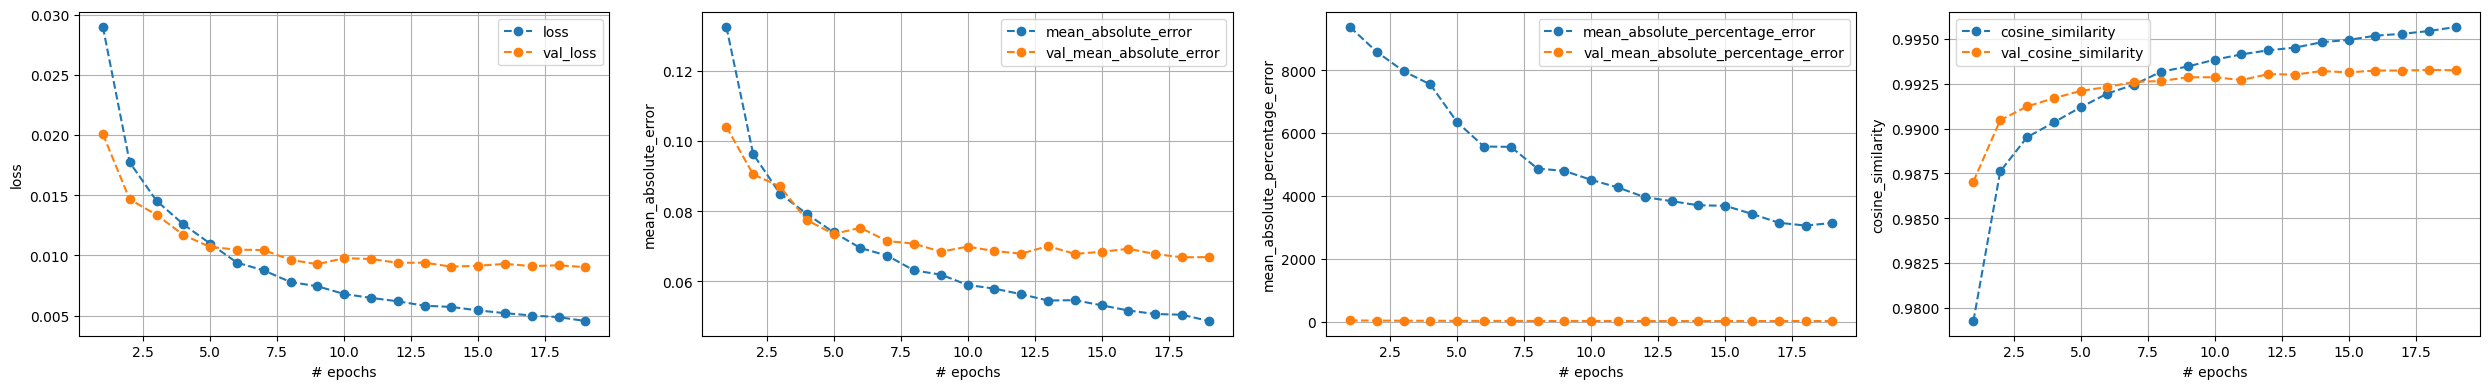

29/29 [==============================] - 1s 34ms/step - loss: 0.0045 - mean_absolute_error: 0.0487 - mean_absolute_percentage_error: 3138.9790 - cosine_similarity: 0.9957 - val_loss: 0.0090 - val_mean_absolute_error: 0.0669 - val_mean_absolute_percentage_error: 18.1672 - val_cosine_similarity: 0.9932


In [23]:
model = Sequential()
model.add(Conv1D(filters=best_params[0], kernel_size=best_params[1], activation='relu', input_shape=(n_steps_in, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(n_steps_out, activation='sigmoid'))
model.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_similarity'])

# Entrenar modelo
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[
                       PlotLearning(),
                       EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=5, restore_best_weights=True)])


In [24]:
# Evaluar modelo
loss, mae, mape, cs = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test MAE:", mae)
print("Test MAPE:", mape)
print("Test Cosine Similarity:", cs)

# Guardamos el modelo
model.save(f'/content/cnn-12h.keras')

5/5 [==============================] - 0s 4ms/step - loss: 0.0090 - mean_absolute_error: 0.0672 - mean_absolute_percentage_error: 14.2806 - cosine_similarity: 0.9926
Test Loss: 0.008970610797405243
Test MAE: 0.06719149649143219
Test MAPE: 14.280632019042969
Test Cosine Similarity: 0.9926152229309082


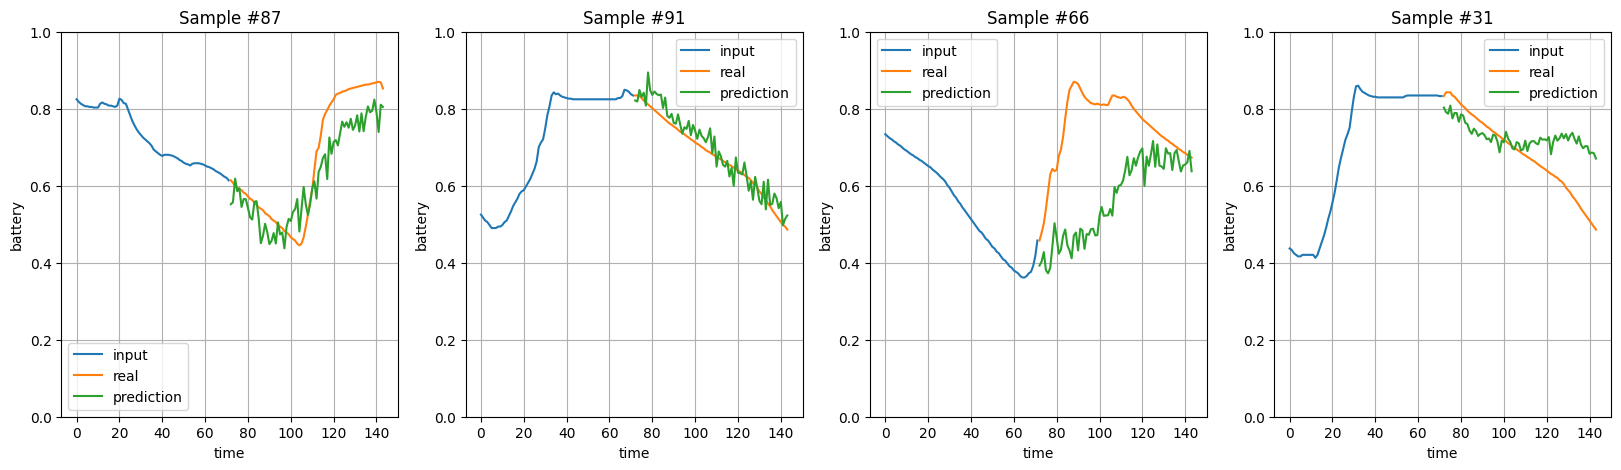

In [25]:
# Predicciones mostradas gráficamente
f, axs = plt.subplots(1,4, figsize=(20, 5))
for w, ax in enumerate(axs):
  item = random.randint(0, len(X_test))
  yhat = model.predict(X_test[item].reshape(1, X_test[item].shape[0], X_test[item].shape[1]), verbose=0)
  ax.plot([i for i in range(n_steps_in)], X_test[item][:, 0], label='input')
  ax.plot([i for i in range(n_steps_in, n_steps_in+n_steps_out)], y_test[item], label='real')
  ax.plot([i for i in range(n_steps_in, n_steps_in+n_steps_out)], yhat[0], label='prediction')
  ax.set_ylim(0, 1)
  ax.set_xlabel('time')
  ax.set_ylabel('battery')
  ax.set_title(f'Sample #{item}')
  ax.legend()
  ax.grid()
plt.show()

Vamos a hacer lo mismo con 6h y 24h.
## 6h

In [41]:
n_steps_in = n_steps_out = 6*6
print(n_steps_in, n_steps_out)

36 36


In [42]:
# Crear datasets de entrenamiento y test
X, y = split_sequences(dfs, n_steps_in, n_steps_out)

seed = 0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=seed)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.66, shuffle=True, random_state=seed) # 0.2 validation y 0.1 test

n_features = X.shape[2]

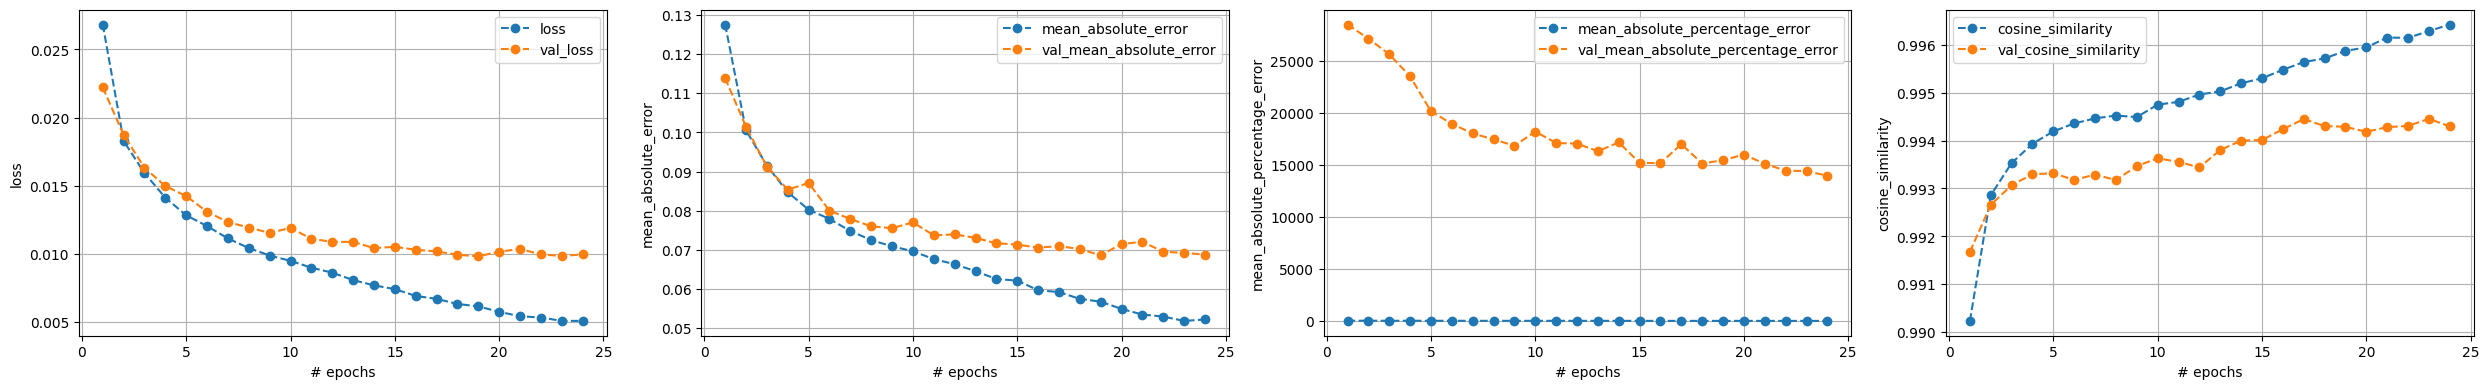

59/59 [==============================] - 1s 19ms/step - loss: 0.0051 - mean_absolute_error: 0.0522 - mean_absolute_percentage_error: 13.7780 - cosine_similarity: 0.9964 - val_loss: 0.0100 - val_mean_absolute_error: 0.0688 - val_mean_absolute_percentage_error: 13969.0791 - val_cosine_similarity: 0.9943


In [43]:
# Definir modelo
model = Sequential()
model.add(Conv1D(filters=best_params[0], kernel_size=best_params[1], activation='relu', input_shape=(n_steps_in, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(n_steps_out, activation='sigmoid'))
model.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_similarity'])

# Entrenar modelo
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[
                       PlotLearning(),
                       EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=5, restore_best_weights=True)])

In [44]:
# Evaluar modelo
loss, mae, mape, cs = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test MAE:", mae)
print("Test MAPE:", mape)
print("Test Cosine Similarity:", cs)

# Guardamos el modelo
model.save(f'/content/cnn-6h.keras')

9/9 [==============================] - 0s 3ms/step - loss: 0.0108 - mean_absolute_error: 0.0728 - mean_absolute_percentage_error: 17.6542 - cosine_similarity: 0.9942
Test Loss: 0.01084635965526104
Test MAE: 0.07278436422348022
Test MAPE: 17.6541690826416
Test Cosine Similarity: 0.9941660165786743


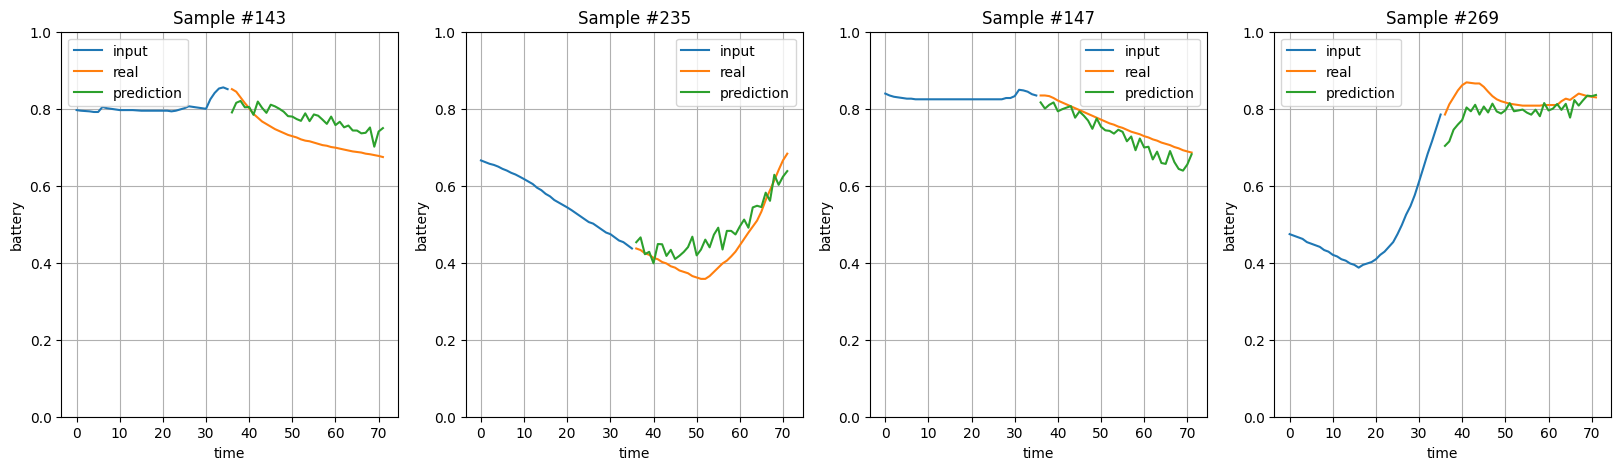

In [45]:
# Predicciones mostradas gráficamente
f, axs = plt.subplots(1,4, figsize=(20, 5))
for w, ax in enumerate(axs):
  item = random.randint(0, len(X_test))
  yhat = model.predict(X_test[item].reshape(1, X_test[item].shape[0], X_test[item].shape[1]), verbose=0)
  ax.plot([i for i in range(n_steps_in)], X_test[item][:, 0], label='input')
  ax.plot([i for i in range(n_steps_in, n_steps_in+n_steps_out)], y_test[item], label='real')
  ax.plot([i for i in range(n_steps_in, n_steps_in+n_steps_out)], yhat[0], label='prediction')
  ax.set_ylim(0, 1)
  ax.set_xlabel('time')
  ax.set_ylabel('battery')
  ax.set_title(f'Sample #{item}')
  ax.legend()
  ax.grid()
plt.show()

## 24h

In [31]:
n_steps_in = n_steps_out = 6*24
print(n_steps_in, n_steps_out)

144 144


In [32]:
# Crear datasets de entrenamiento y test
X, y = split_sequences(dfs, n_steps_in, n_steps_out)

seed = 0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=seed)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.66, shuffle=True, random_state=seed) # 0.2 validation y 0.1 test

n_features = X.shape[2]

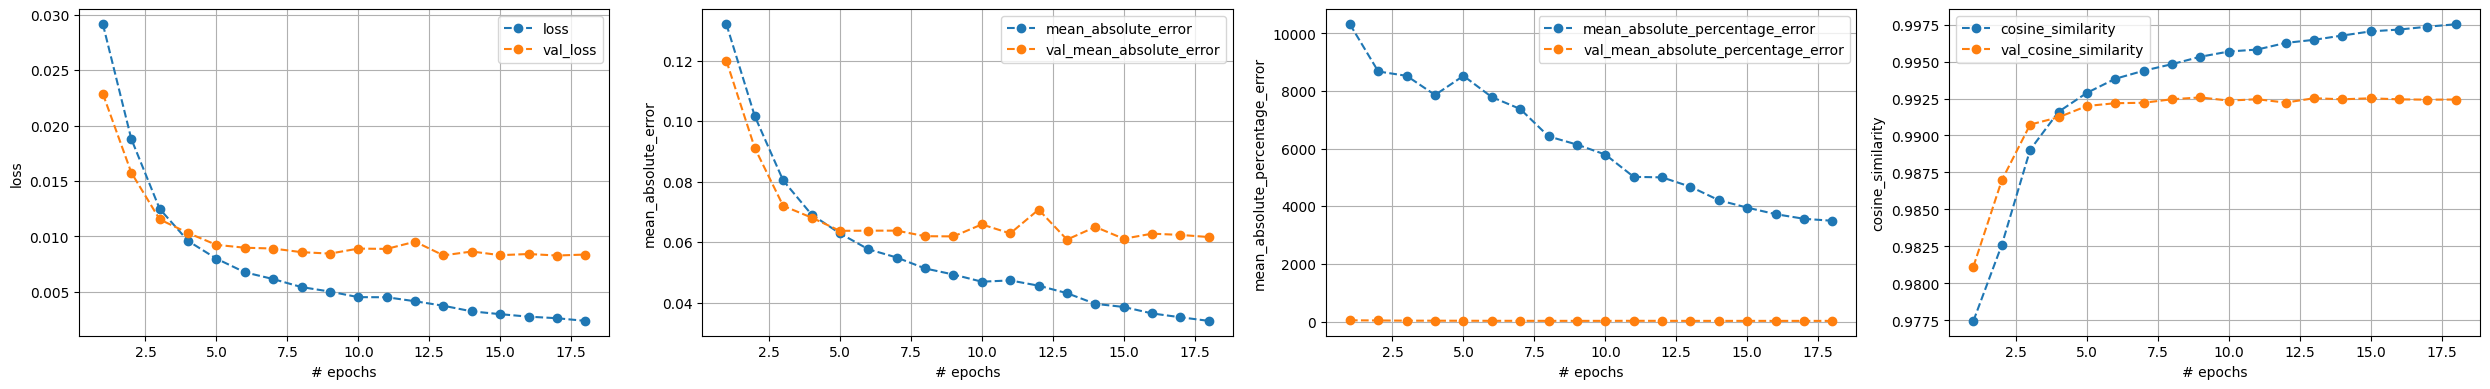

15/15 [==============================] - 1s 63ms/step - loss: 0.0024 - mean_absolute_error: 0.0340 - mean_absolute_percentage_error: 3496.0322 - cosine_similarity: 0.9975 - val_loss: 0.0084 - val_mean_absolute_error: 0.0617 - val_mean_absolute_percentage_error: 22.3647 - val_cosine_similarity: 0.9924


In [33]:
# Definir modelo
model = Sequential()
model.add(Conv1D(filters=best_params[0], kernel_size=best_params[1], activation='relu', input_shape=(n_steps_in, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(n_steps_out, activation='sigmoid'))
model.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_similarity'])

# Entrenar modelo
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[
                       PlotLearning(),
                       EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=5, restore_best_weights=True)])

In [36]:
# Evaluar modelo
loss, mae, mape, cs = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test MAE:", mae)
print("Test MAPE:", mape)
print("Test Cosine Similarity:", cs)

# Guardamos el modelo
model.save(f'/content/cnn-24h.keras')

3/3 [==============================] - 0s 6ms/step - loss: 0.0101 - mean_absolute_error: 0.0652 - mean_absolute_percentage_error: 18.4227 - cosine_similarity: 0.9909
Test Loss: 0.010136333294212818
Test MAE: 0.06519515812397003
Test MAPE: 18.42267608642578
Test Cosine Similarity: 0.9909233450889587


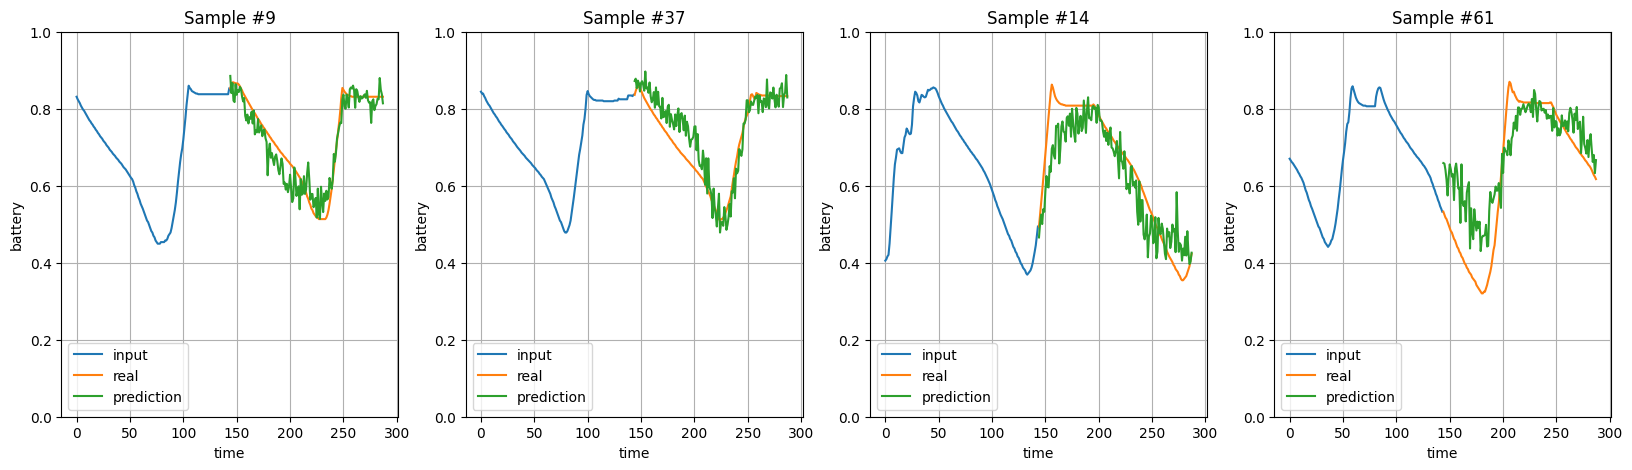

In [35]:
# Predicciones mostradas gráficamente
f, axs = plt.subplots(1,4, figsize=(20, 5))
for w, ax in enumerate(axs):
  item = random.randint(0, len(X_test))
  yhat = model.predict(X_test[item].reshape(1, X_test[item].shape[0], X_test[item].shape[1]), verbose=0)
  ax.plot([i for i in range(n_steps_in)], X_test[item][:, 0], label='input')
  ax.plot([i for i in range(n_steps_in, n_steps_in+n_steps_out)], y_test[item], label='real')
  ax.plot([i for i in range(n_steps_in, n_steps_in+n_steps_out)], yhat[0], label='prediction')
  ax.set_ylim(0, 1)
  ax.set_xlabel('time')
  ax.set_ylabel('battery')
  ax.set_title(f'Sample #{item}')
  ax.legend()
  ax.grid()
plt.show()